In [13]:
from env import *
from env_tradestation import *
from data_retriever_simple import Client
import acquire
import prepare

import cbpro
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import warnings
warnings.filterwarnings("ignore")

Basis for much of this: https://jfin-swufe.springeropen.com/track/pdf/10.1186/s40854-020-00217-x.pdf

# Personal Project - Compare the ability to predict cryptocurrency and futures prices using machine learning

## Start with acquiring crypto data
- Will acquire Bitcoin, Ethereum, and Litecoin data as these have some of the longest price histories and greatest liquidity

In [2]:
desired_products = ['BTC-USD',
 'ETH-USD',
 'LTC-USD']

In [3]:
results = acquire.get_data_from_csv()

In [4]:
prepared_results = prepare.prepare_crypto_data(results)

Max first date is 2016-08-17 00:00:00, starting all dataframes at this day
Corrected btc low data for 2017-04-15


### First iteration only using BTC

In [5]:
btc=prepared_results['BTC_USD']

No nulls

### Volatility:
- relative price range: RR
- range volatility estimator of Parkinson: sigma  - lags 1-7

#### Lagged log returns, 1-7 days earlier

In [6]:
btc = prepare.add_features(btc)

## Split data

In [7]:
train_size = int(len(btc) * .5)
validate_size = int(len(btc) * .3)
test_size = int(len(btc) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = btc[: train_size]
validate = btc[train_size : validate_end_index]
test = btc[validate_end_index : ]

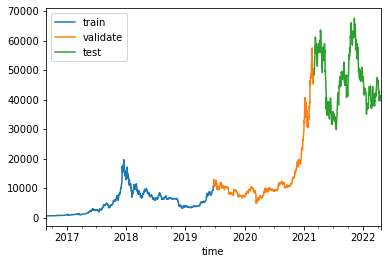

In [8]:
train.close.plot(label='train')
validate.close.plot(label='validate')
test.close.plot(label='test')
plt.legend()

# Modeling
- Will start with ARIMA
- After ARIMA will try regression and classification models

### Arima
- Will set up a grid search for best parameters to use
- Based on https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
- No validate dataset needed as ARIMA will perform one day prediction and then will be retrained for next day

In [12]:
result=adfuller(train.fwd_log_ret)
print("AD Fuller p stat < 0.05", result[1]<0.05)

AD Fuller p stat < 0.05 True


#### No differencing needed

### Partial Autocorrelation plot - for AR (p) term

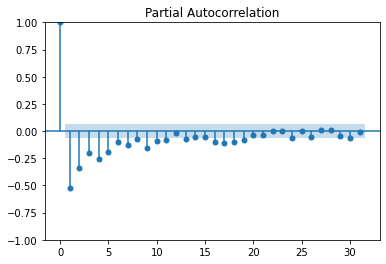

In [15]:
plot_pacf(train.fwd_log_ret.diff().dropna())
plt.show()

Looks like lags from 1-10 are significant.

### Autocorrelation plot (q) term

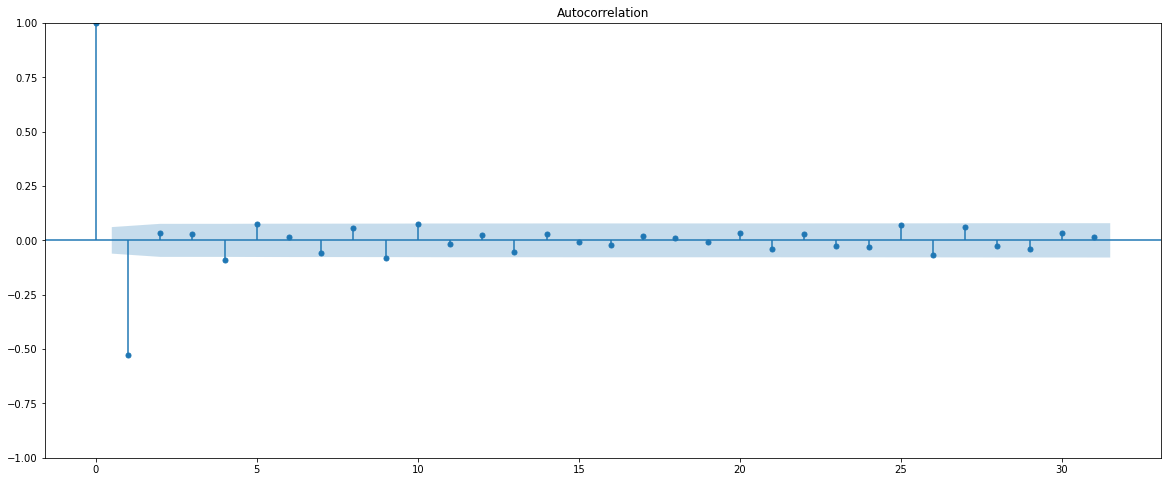

In [22]:
plt.rcParams.update({'figure.figsize':(20,8)})
plot_acf(train.fwd_log_ret.diff().dropna())
plt.show()

### Fix q as 1

In [24]:
def evaluate_arima_model(train, test, target, arima_order):
    """ Evaluates an ARIMA model based on arima_order argument, train set, test set, and target. 
    Outputs error and predictions for every  timestep in test"""
    train_target = train[target]
    test_target = test[target]
    history = [x for x in train_target]

    # Make predictions
    predictions = []
    for t in range(len(test_target)):
        print(f"\tTesting {arima_order} {t}/{len(test_target)}", end="\r")
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        # Forecast returns forecast value, standard error, and confidence interval - only need forecast value ([0])
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # Adds the latest test value to history so it can be used to train
        history.append(test_target[t])
    error = mean_squared_error(test_target, predictions)
    print("\n")
    return error, test_target, predictions

In [25]:
def evaluate_models(train, test, target, p_values, d_values, q_values):
    mses=[]
    prediction_list=[]
    actual_test = []
    orders = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                orders.append(order)
                try:
                    mse, test_target, predictions = evaluate_arima_model(train, test, target, order)
                    mses.append(mse)
                    prediction_list.append(predictions)
                    actual_test.append(test_target)
                except KeyboardInterrupt:
                    print("Keyboard interrupt")
                    raise
                except:
                    print(f"{order} didn't work, continuing with next order")
                    continue
    results_df = pd.DataFrame.from_records(orders, columns = ['p','d','q'])
    results_df["mse"] = mses
    results_df["test_predictions"] = prediction_list
    results_df["test_actual"] = actual_test
    return results_df

In [29]:
p_values = list(range(8))



In [ ]:
p_values = list(range(8))
d_values = [0]
q_values = [1]
results_df = evaluate_models(train, validate, 'fwd_log_ret', p_values, d_values, q_values)

	Testing (0, 0, 1) 619/620

	Testing (1, 0, 1) 619/620

	Testing (2, 0, 1) 619/620

	Testing (3, 0, 1) 619/620

	Testing (4, 0, 1) 619/620



In [80]:
results_df

,p,d,q,mse,test_predictions,test_actual
0,1,3,3,0.003792,"[-0.004839391428457039, -0.006010558463146194,...",time 2019-05-01 -0.012858 2019-05-02 -0.04...


In [89]:
real = results_df.test_actual[0]
predictions = results_df.test_predictions[0]

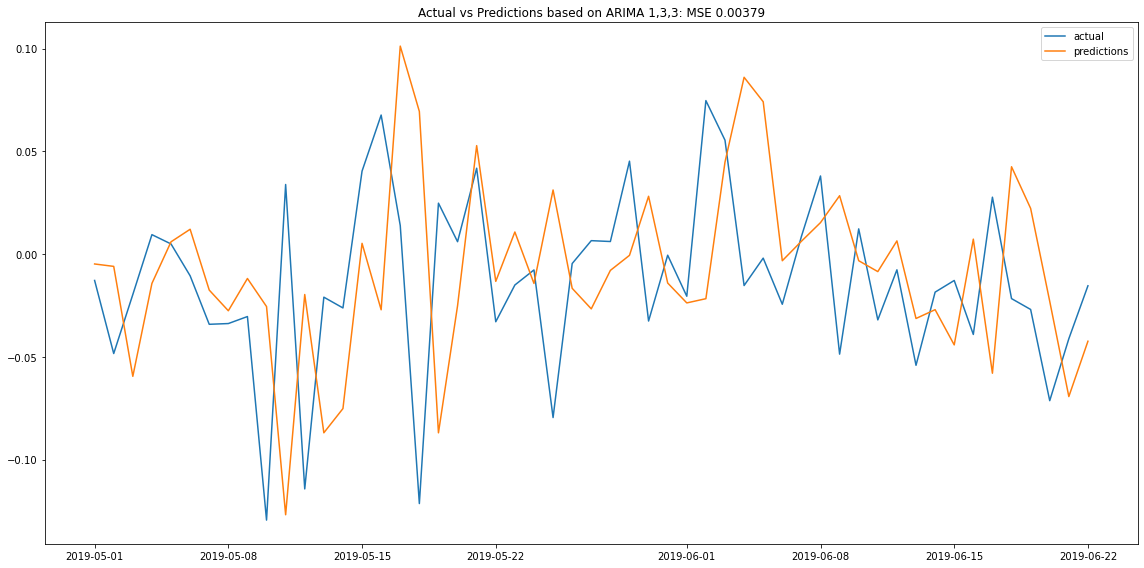

In [103]:
plt.figure(figsize=(16,8))
plt.plot(train.iloc[980:].fwd_log_ret, label = "actual")
plt.plot(train.iloc[980:].index, predictions, label = "predictions")
plt.title(f"Actual vs Predictions based on ARIMA 1,3,3: MSE {results_df.mse[0]:.5f}")
plt.legend()
plt.tight_layout()

In [66]:
arima_results = pd.DataFrame.from_records(pdqs, columns = ['p','d','q'])

In [67]:
arima_results["mse"] = res

In [70]:
arima_results.sort_values('mse').head(5)

,p,d,q,mse
17,1,2,2,0.001813
8,0,2,2,0.001846
2,0,0,2,0.001849
18,2,0,0,0.001850
23,2,1,2,0.001855


### Best ARIMA parameters based on gridsearch of:
p_values = [0,1,2]
d_values = [0,1,2]
q_values = [0,1,2]
- (p,d,q) = (1,2,2) -> MSE of 0.001813
- 2 is top q (MA term - number of lagged forecast errors)
- 2 is top d value (min numnber of differencing needed to make series stationary)
- 1 and 0 top p value (AR) - number of lags of Y to be used as predictors

## Evaluate regression models

In [ ]:
def evaluate_regression_model(train, validate, test, target, features_to_use, model):
    
    X_train = train[features_to_use]
    X_validate = validate[features_to_use]
    X_test = test[features_to_use]
    
    train_target = train[target]
    validate_target = validate[target]
    test_target = test[target]
    
    
    history = [x for x in train_target]

    # Make predictions
    predictions = []
    for t in range(len(test_target)):
        print(f"\tTesting {arima_order} {t}/{len(test_target)}", end="\r")
        model = model
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # Adds the latest test value to history so it can be used to train
        history.append(test_target[t])
    error = mean_squared_error(test_target, predictions)
    print("\n")
    return error

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict G3_pred_mean
G3_pred_mean = y_train['G3'].mean()
y_train['G3_pred_mean'] = G3_pred_mean
y_validate['G3_pred_mean'] = G3_pred_mean

# 2. compute G3_pred_median
G3_pred_median = y_train['G3'].median()
y_train['G3_pred_median'] = G3_pred_median
y_validate['G3_pred_median'] = G3_pred_median

# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
